# exponential smoothing model

# Loading and Manipulating the Data

In [ ]:
from darts import TimeSeries
import pandas as pd
from darts.models import ExponentialSmoothing
from darts.utils.utils import SeasonalityMode
from darts.utils.utils import ModelMode
from darts.metrics import rmse, mae

In [1]:
import pandas as pd
df_master = pd.read_pickle('/path/to/pklFiles/df_master.pkl')

In [2]:
df_master.columns

Index(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'd',
       'sales', 'release', 'wm_yr_wk', 'sell_price', 'price_max', 'price_min',
       'price_std', 'price_mean', 'price_norm', 'price_nunique',
       'item_nunique', 'price_momentum', 'price_momentum_m',
       'price_momentum_y', 'event_name_1', 'event_type_1', 'event_name_2',
       'event_type_2', 'snap_CA', 'snap_TX', 'snap_WI', 'tm_d', 'tm_m', 'tm_y',
       'tm_wm', 'tm_dw', 'tm_w_end', 'date'],
      dtype='object')

In [3]:
df_master = df_master.sort_values(['id', 'date'])
df_master.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,release,wm_yr_wk,...,snap_CA,snap_TX,snap_WI,tm_d,tm_m,tm_y,tm_wm,tm_dw,tm_w_end,date
576,CA_1_FOODS_1_001,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,1,3.0,0,11101,...,0,0,0,29,1,0,5,5,1,2011-01-29
11508,CA_1_FOODS_1_001,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,2,0.0,0,11101,...,0,0,0,30,1,0,5,6,1,2011-01-30
22440,CA_1_FOODS_1_001,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,3,0.0,0,11101,...,0,0,0,31,1,0,5,0,0,2011-01-31
33372,CA_1_FOODS_1_001,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,4,1.0,0,11101,...,1,1,0,1,2,0,1,1,0,2011-02-01
44304,CA_1_FOODS_1_001,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,5,4.0,0,11101,...,1,0,1,2,2,0,1,2,0,2011-02-02


creating a smaller Dataframe for this simple Model

In [4]:
df_master_smaller = df_master[['id', 'date','d', 'sales']].copy()
del df_master

Creating the timeseries with Darts

In [5]:
from darts import TimeSeries
# Dictionaries for storing the series
target_series_dict = {}

# Group by 'id' to isolate each item+store
for i_id, group_df in df_master_smaller.groupby('id', sort=False, observed=False):
    # Sort within the group by date (just to be safe)
    group_df = group_df.sort_values('date')
    
    # --- TARGET SERIES (sales) ---
    target_series = TimeSeries.from_dataframe(
        df=group_df,
        time_col='date',       # The column that holds your dates
        value_cols='sales',    # The column(s) you want as your target
        freq='D'               # Daily frequency (adjust if your data is weekly, etc.)
    )
    
    # Store in the dictionaries
    target_series_dict[i_id] = target_series

print(f"Created {len(target_series_dict)} target series")

Created 30490 target series


Checking the type of my data

In [6]:
some_id = list(target_series_dict.keys())[0]
print(target_series_dict[some_id].dtype)  

float64


Splitting the training and validation Timeseries to Lists of Timeseries

In [7]:
import numpy as np

train_target_dict = {}
test_target_dict = {}


all_ids = (target_series_dict.keys())
#forecast_horizon = 28  # e.g., 28 days of validation

for i_id, target_series in target_series_dict.items():

    #print(i_id)

    train_target, test_target = target_series[:-28], target_series[-28:]

    # --- CAST HERE to float32 ---
    train_target = train_target.astype(np.float32)
    test_target = test_target.astype(np.float32)

    train_target_dict[i_id] = train_target
    test_target_dict[i_id] = test_target


print(f"Number of series: {len(all_ids)}")
print(f"Example training series length: {train_target_dict['CA_1_FOODS_1_001'].n_timesteps}")
print(f"Example validation series length: {test_target_dict['CA_1_FOODS_1_001'].n_timesteps}")

Number of series: 30490
Example training series length: 1941
Example validation series length: 28


In [8]:
print(train_target_dict['CA_1_FOODS_1_001'].dtype)        # should be float32

float32


# Training
actually training all my dataset

In [9]:
all_ids = list(all_ids)

In [10]:
from darts.models import ExponentialSmoothing
from tqdm.notebook import tqdm
from darts.utils.utils import SeasonalityMode
from darts.utils.utils import ModelMode


forecasts_dict = {}
for i_id in tqdm(target_series_dict.keys(), total=len(target_series_dict.keys()), desc="Forecasting series"):
    # Prepare training & validation series
    # (assuming train_target_list and val_target_list have the same order as all_ids)
    #train_series = train_target_list[i]

    
    # Initialize ARIMA model
    model = ExponentialSmoothing(trend=ModelMode.ADDITIVE, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7,random_state=42)
    
    # Fit
    model.fit(train_target_dict[i_id])
    
    # Predict
    forecast = model.predict(n=28)
    
    # Store the forecast
    forecasts_dict[i_id] = forecast
    
    # Optional: Print info about each forecast
    #print(f"Forecasted {i_id}")

Forecasting series:   0%|          | 0/30490 [00:00<?, ?it/s]

# Evaluation and Statistics

# Weighted eval

Reading the weights provided by the M5 competition to compute the WRMSSE

In [11]:
import pandas as pd 
weights_df = pd.read_csv("/path/to/ExtraFiles/weights_validation.csv")

# We only want rows for Level12
weights_df = weights_df[weights_df["Level_id"] == "Level12"].copy()

# Create a new 'id' column by combining Agg_Level_1 and Agg_Level_2
weights_df["id"] =weights_df["Agg_Level_2"] + "_" + weights_df["Agg_Level_1"] 


weights_df = weights_df.sort_values(['id'])
# Build a dictionary: {id_string: weight_value}
weights_map = dict(zip(weights_df["id"], weights_df["weight"]))

In [12]:
from darts.metrics import rmse,mae,rmsse
wrmsse_list = []

for i_id in all_ids:
    weight_value = weights_map[i_id]
    wrmsse_value = weight_value*rmsse(actual_series=test_target_dict[i_id],pred_series=forecasts_dict[i_id], insample=train_target_dict[i_id])
    wrmsse_list.append(wrmsse_value)

In [13]:
print(f"WRMSSE = {sum(wrmsse_list)}")

WRMSSE = 0.8881092269729152


# Normal RMSE

<Axes: xlabel='date'>

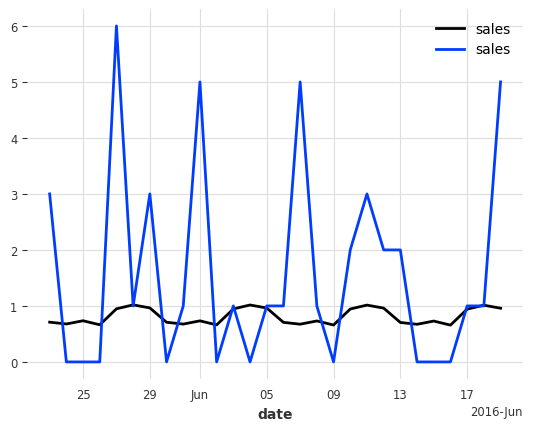

In [14]:
forecasts_dict['CA_1_FOODS_1_001'].plot()
test_target_dict['CA_1_FOODS_1_001'].plot()

In [15]:
rmse_list = []
mae_list = []
for i_id in all_ids:
    forecast = forecasts_dict[i_id]
    val_series = test_target_dict[i_id]

    error_rmse = rmse(val_series, forecast)
    error_mae = mae(val_series,forecast)
    rmse_list.append(error_rmse)
    mae_list.append(error_mae)

mean_rmse = np.mean(rmse_list)
mean_mae = np.mean(mae_list)

# Print the mean RMSE
print(f"\nMean RMSE across all series: {mean_rmse:.2f}")
print(f"\nMean MAE across all series: {mean_mae:.2f}")


Mean RMSE across all series: 1.44

Mean MAE across all series: 1.11


# ETC

In [16]:
# Create a DataFrame with 'id' and 'RMSE'
metrics_df = pd.DataFrame({
    'id': all_ids,
    'RMSE': rmse_list
})


In [17]:
# Calculate additional statistics
mean_rmse = metrics_df['RMSE'].mean()
median_rmse = metrics_df['RMSE'].median()
std_rmse = metrics_df['RMSE'].std()
min_rmse = metrics_df['RMSE'].min()
max_rmse = metrics_df['RMSE'].max()

# Print the statistics
print("\nRMSE Statistics:")
print(f"Mean RMSE: {mean_rmse:.2f}")
print(f"Median RMSE: {median_rmse:.2f}")
print(f"Standard Deviation of RMSE: {std_rmse:.2f}")
print(f"Minimum RMSE: {min_rmse:.2f}")
print(f"Maximum RMSE: {max_rmse:.2f}")



RMSE Statistics:
Mean RMSE: 1.44
Median RMSE: 0.93
Standard Deviation of RMSE: 1.98
Minimum RMSE: 0.17
Maximum RMSE: 60.94


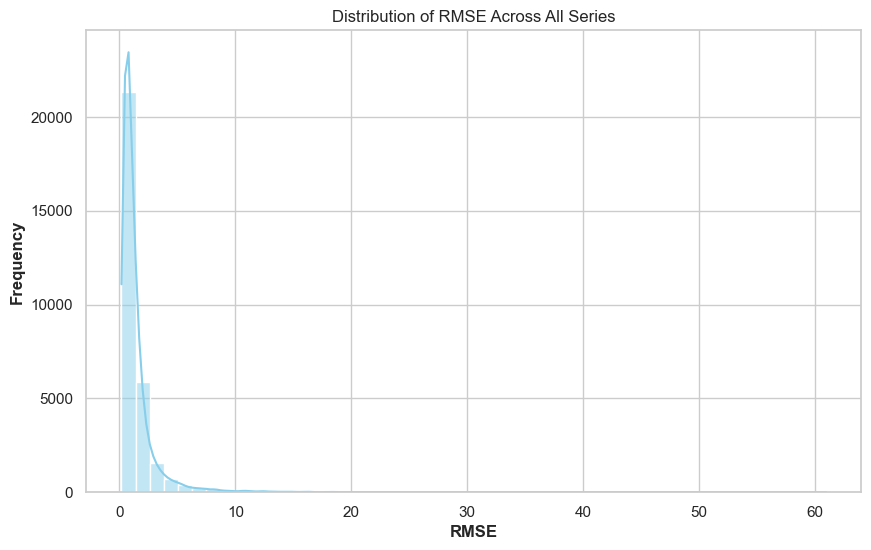

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Plot a histogram of RMSE values
plt.figure(figsize=(10, 6))
sns.histplot(metrics_df['RMSE'], bins=50, kde=True, color='skyblue')
plt.title('Distribution of RMSE Across All Series')
plt.xlabel('RMSE')
plt.ylabel('Frequency')
plt.show()


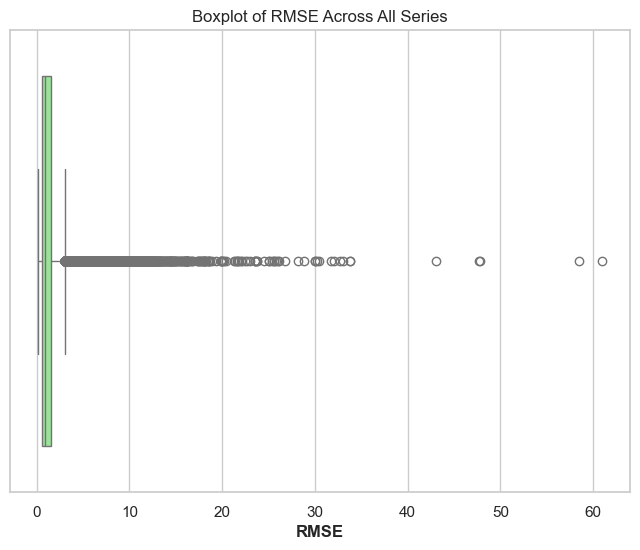

In [19]:
# Plot a boxplot of RMSE values
plt.figure(figsize=(8, 6))
sns.boxplot(x=metrics_df['RMSE'], color='lightgreen')
plt.title('Boxplot of RMSE Across All Series')
plt.xlabel('RMSE')
plt.show()


In [20]:
# Identify the top 5 series with the highest RMSE
top5_highest_rmse = metrics_df.sort_values(by='RMSE', ascending=False).head(5)
print("Top 5 Series with Highest RMSE:")
print(top5_highest_rmse)

# Identify the top 5 series with the lowest RMSE
top5_lowest_rmse = metrics_df.sort_values(by='RMSE').head(5)
print("\nTop 5 Series with Lowest RMSE:")
print(top5_lowest_rmse)


Top 5 Series with Highest RMSE:
                     id       RMSE
24966  WI_2_FOODS_2_360  60.935095
7515   CA_3_FOODS_3_808  58.485213
6800   CA_3_FOODS_3_090  47.831282
732    CA_1_FOODS_3_120  47.741065
25074  WI_2_FOODS_3_070  43.009505

Top 5 Series with Lowest RMSE:
                         id      RMSE
5966   CA_2_HOUSEHOLD_2_385  0.170571
19640      TX_3_FOODS_3_736  0.173671
30102  WI_3_HOUSEHOLD_2_128  0.174899
15711      TX_2_FOODS_2_252  0.175738
13753    TX_1_HOBBIES_1_125  0.176383
